In [31]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_human_functions import heatmap, normalize_by_l2_norm, mse_matrix, Nexis_error
from functools import partial
from scipy.stats import pearsonr

## Nexis

In [32]:

class run_Nexis:
    def __init__(self,C_,U_,init_vec_,t_vec_,w_dir_=0,volcorrect_=0,use_baseline_=0,region_volumes_=[], logistic_term_=0, datadir_=''):
        self.C = C_ # Connectivity matrix, nROI x nROI
        self.U = U_ # Matrix or vector of cell type or gene expression, nROI x nTypes
        self.init_vec = init_vec_ # Binary vector indicating seed location OR array of baseline pathology values, nROI x 1
        self.t_vec = t_vec_ # Vector of time points to output model predictions, 1 x nt
        self.volcorrect = volcorrect_ # Binary flag indicating whether to use volume correction - ask ben 
        self.w_dir = w_dir_ # Binary flag indicating whether to use directionality or not 
        self.use_baseline = use_baseline_ # Binary flag indicating whether you are using baseline or a binary seed to initialize the model
        self.region_volumes = region_volumes_ # Array of region volumes, nROI x 1 if applicable
        self.logistic_term = logistic_term_ 
        
        if (datadir_==''):
            curdir = os.getcwd()
            subdir = 'raw_data_mouse'
            datadir_ = os.path.join(curdir,subdir)
        self.datadir = datadir_ # Directory to load dependences from

    def simulate_nexis(self, parameters):
        """
        Returns a matrix, Y, that is nROI x nt representing the modeled Nexis pathology
        given the provided parameters. alpha, beta, and gamma should be nonnegative scalars;
        s should be bounded between 0 and 1; b and p should be nCT-long vectors
        """
        # Define parameters
        ntypes = np.size(self.U,axis=1)
        alpha = parameters[0] # global connectome-independent growth (range [0,5])
        beta = parameters[1] # global diffusivity rate (range [0,5])
        if self.use_baseline:
            gamma = 1
        else:
            gamma = parameters[2] # seed rescale value (range [0,10])
        if self.w_dir==0:
            s = 0.5
        else:
            s = parameters[3] # directionality (0 = anterograde, 1 = retrograde)
        b = np.transpose(parameters[4:(ntypes+4)]) # cell-type-dependent spread modifier (range [-5,5])
        p = np.transpose(parameters[(ntypes+4):6]) # cell-type-dependent growth modifier (range [-5,5]) #EDITED
        k = parameters[6] # Carrying capacity ADDED
        
        # Define starting pathology x0
        x0 = gamma * self.init_vec
        
        # Define diagonal matrix Gamma containing spread-independent terms
        s_p = np.dot(self.U,p)
        Gamma = np.diag(s_p) + (alpha * np.eye(len(s_p))) 

        # Define Laplacian matrix L
        C_dir = (1-s) * np.transpose(self.C) + s * self.C
        coldegree = np.sum(C_dir,axis=0)
        L_raw = np.diag(coldegree) - C_dir
        s_b = np.dot(self.U,b)
        s_b = np.reshape(s_b,[len(s_b),1])
        S_b = np.tile(s_b,len(s_b)) + np.ones([len(s_b),len(s_b)])
        L = np.multiply(L_raw,np.transpose(S_b))

        # Apply volume correction if applicable
        if self.volcorrect:
            voxels_2hem = self.region_volumes

            inv_voxels_2hem = np.diag(np.squeeze(voxels_2hem).astype(float) ** (-1))
            
            L = np.mean(voxels_2hem) * np.dot(inv_voxels_2hem,L)

        # Define system dydt = Ax
        A = Gamma - (beta * L)

        # Solve 
        if self.logistic_term:
            y = self.sim_logistic(self.t_vec,x0,A,Gamma,k) 
        else:
            y = self.forward_sim(A,self.t_vec,x0)

        return y
    
    # Solve via analytic method (no logistic term)
    def forward_sim(self,A_,t_,x0_):
        y_ = np.zeros([np.shape(A_)[0],len(t_)])
        for i in list(range(len(t_))):
            ti = t_[i]
            y_[:,i] = np.dot(expm(A_*ti),np.squeeze(x0_)) 
        return y_
    
    # Solve via odeint with logistic term
    def sim_logistic(self,t_,x0_,A_,Gamma_,k_):

        # Define ODE function with a logistic term
        def ode_func(y, t, A, Gamma, k):
            dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k
            return dydt

        # Initial condition
        y0 = x0_

        # Solve ODE using odeint
        sol = odeint(ode_func, y0, t_, args=(A_,Gamma_,k_))

        # Transpose so that sol is an array with dim nROI x time points
        sol = sol.T

        return sol

## Preparing Inputs

In [46]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix original.csv')

# List of striatal regions to exclude from further analysis CAN EDIT THIS
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix 
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

In [47]:
# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'baseline' 

# Conversion of ADNI region order to match connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    init_con = pandas.read_csv('Regional tau time series - cerbellum normalized.csv')

    # Housekeeping
    init_con = init_con.drop('Unnamed: 0',axis=1)

    # Reorder regions 
    init_con_reordered = init_con.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    init_vec = init_con_excluded.iloc[0].values

    # Set use_baseline NEXIS input to 1 to indicate use of baseline data as initial vector  
    use_baseline_ = 1 

# Binary vector indicating seeding location 
if init_vec_method == 'binary': 

    seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # MANUALLY EDIT SEEDING LOCATION HERE
    seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding locations to 1 (both left and right hemisphere)
    init_vec[seeding_indices[0]] = 1 
    init_vec[seeding_indices[1]] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

In [48]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Conversion of DK region order to match that of connectivity matrix 
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [6]:
# LOAD GENE DATA HERE (assuming DK region order)
gene_data = pandas.read_csv('')

# Select genes of choice (should be a matrix of nROI x number of genes)
gene_data = gene_data.iloc[:, ___]

# Reorder and delete striatal regions 
gene_data_reordered = gene_data[new_order_DK, :]
gene_data_excluded = np.delete(gene_data_reordered,excluded_indices)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [56]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
init_vec_ = init_vec # Initial tau vector (nROI x 1)
t_vec_ = np.linspace(0, 18, 19)  # Time vector in terms of stages outputted by EBM (19 stages)
w_dir_ = 0  # Set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without
datadir_ = "../NDM output/NDM_output.csv"  # Data directory for output

# Cell type matrix (nROI x nTypes)
U_global_= np.zeros((nROI, 1))
U_gene_= np.random.rand(nROI, 1) # CHANGE TO 'gene_data_excluded' once gene data is uploaded

## Load Patient Data

In [50]:
# Upload patient data
patient_data = pandas.read_csv('Longitudinal stage and regional tau.csv')

# Reorder regions
subset_columns = patient_data.columns[3:][new_order_ADNI]  
final_columns = list(patient_data.columns[:3]) + list(subset_columns)
patient_data = patient_data[final_columns]

# Delete striatal regions 
patient_data = patient_data.drop(regions_to_exclude, axis = 1)

In [51]:
# If analyzing an individual patient... (use this to test that the model is working before looping through all patients)

patient = patient_data[patient_data['RID'] == 31] # MANUALLY SET RID HERE

# Define number of time points 
num_time_points = patient.shape[0]

# Define list with stage assingments for each time point 
stages = patient['ml_stage'].tolist()
stages = [int(x) for x in stages]

# Define patient tau data
patient_tau = patient.iloc[:,3:]

# Convert to array and transpose so dim = nROI x # of stages
patient_tau = patient_tau.to_numpy()
patient_tau = patient_tau.T

## Parameter Optimization

In [59]:
# Initialize nexis global
nexis_model_global = run_Nexis(C_=C_, U_=U_global_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

# Initialize nexis gene 
nexis_model_gene = run_Nexis(C_=C_, U_=U_gene_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                         region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

# Customize error function for patient tau, stages, and version of Nexis (gene and global)
custom_Nexis_error_global = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_global)
custom_Nexis_error_gene = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_gene)

# Initial guesses for parameters (alpha, beta, gamma, s, b, p, k) CAN ADJUST THESE
init_guess = np.array([0.04, 1.01, 1, 0.5, 0, 0.07, 20])

# Bounds for each parameter [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. CAN ADJUST THESE
bounds = [(0, 2),(0, 5),(0,3),(0.5,0.5),(0,1),(0,1),(0,50)]

# Perform the optimization (currently set to global)
result = minimize(custom_Nexis_error_global, init_guess, bounds=bounds, method='L-BFGS-B', 
                  options={'ftol': 1e-6, 'gtol': 1e-6})

# Check the results
if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist( )
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.0, 0.03348194749537978, 1.0, 0.5, 0.0, 0.07, 19.999999265183195]


## Running Nexis

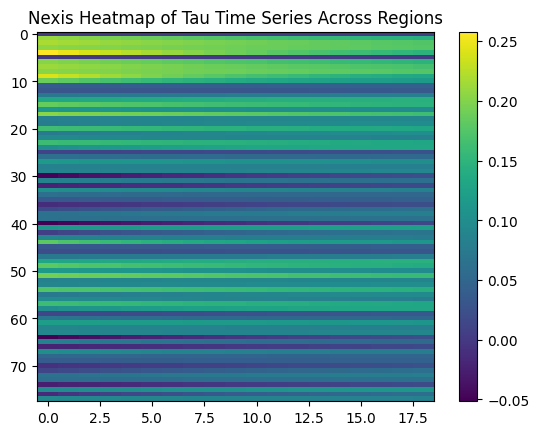

In [53]:
# Parameters for simulate_nexis method
parameters = optimized_params  # (alpha, beta, gamma, s, b, p, k) CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the optimized parameters (currently set to global)
Y = nexis_model_global.simulate_nexis(parameters)

# Take stages from Y that correspond to patient's stages 
Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap(init_vec_method, Y)

## Check Results

In [54]:
# Calculate Pearson's corelation coefficient R 
patient_tau_reshaped = patient_tau.reshape(-1)
Y_edited_reshaped = Y_edited.reshape(-1)
R, p_value = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
print("Pearson's R:", R)
print("P-value:", p_value)

Pearson's R: 0.7962358138555741
P-value: 1.9663598267673566e-35


<function matplotlib.pyplot.show(close=None, block=None)>

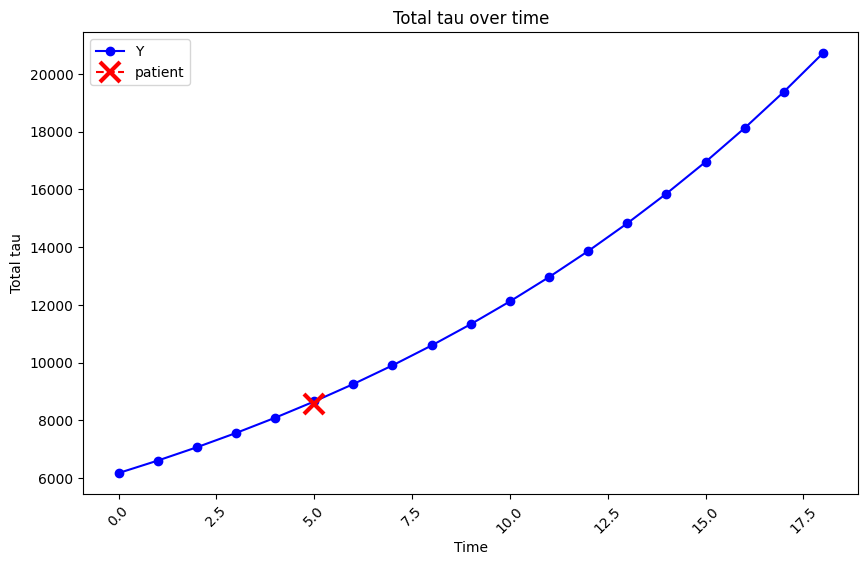

In [38]:
# Plot total tau over time to check that the scale of Y matches that of patient data

# Calculate total tau based on regional volumes and tau density 
regional_volumes_array = np.array(regional_volumes_excluded)
regional_volumes_array = regional_volumes_array.reshape((78,1))
tau_mass_Y = regional_volumes_array * Y 
total_tau_Y = np.sum(tau_mass_Y, axis=0)
tau_mass_patient = regional_volumes_array * patient_tau
total_tau_patient = np.sum(tau_mass_patient, axis=0)

time_points_Y = np.linspace(0, 18, 19)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

# Plot total_tau_patient on the same graph
plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)
plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show

## Loop through all patients

In [61]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

# Create a dictionary of delta R squared values for each RID
R_dict = {}

# Loop through all patients 
for rid in [21,31]:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T
    patient_tau_reshaped = patient_tau.reshape(-1)

    # Run Nexis global and calculate R squared
    result = minimize(custom_Nexis_error_global, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-6, 'gtol': 1e-6})
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )
    parameters = optimized_params  
    Y = nexis_model_global.simulate_nexis(parameters)
    Y_edited = Y[:, stages]
    Y_edited_reshaped = Y_edited.reshape(-1)
    R_global, p_value_global = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
    R_squared_global = R_global ** 2


    # Run Nexis with gene and calculate R squared
    result = minimize(custom_Nexis_error_gene, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-6, 'gtol': 1e-6})
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )
    parameters = optimized_params  
    Y = nexis_model_gene.simulate_nexis(parameters)
    Y_edited = Y[:, stages]
    Y_edited_reshaped = Y_edited.reshape(-1)
    R_gene, p_value_gene = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
    R_squared_gene = R_gene ** 2

    # Calculate delta R sqaured and add to dictionary
    delta_R = R_squared_global - R_squared_gene
    R_dict[str(rid)] = delta_R

# Print R_dict
print('Delta R squared for each RID:')
R_dict

Delta R squared for each RID:


{'21': -0.0023461806783207084, '31': 0.041984782509600915}